<a href="https://colab.research.google.com/github/ChristianConchari/Strathospheric-ballon-earth-observation-gathered-imagery-classification-through-TinyML/blob/master/classification_model_ballon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and loading the data

In [28]:
from tensorflow import keras
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from  tensorflow.keras import optimizers

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/data_training_balloon.zip
!mkdir data_training_balloon 
!mv 0 data_training_balloon
!mv 1 data_training_balloon

Archive:  /content/gdrive/MyDrive/data_training_balloon.zip
   creating: 0/
  inflating: 0/1.png                 
  inflating: 0/2.png                 
  inflating: 0/3.png                 
  inflating: 0/4.png                 
  inflating: 0/5.png                 
  inflating: 0/6.png                 
  inflating: 0/7.png                 
  inflating: 0/8.png                 
  inflating: 0/9.png                 
  inflating: 0/10.png                
  inflating: 0/11.png                
  inflating: 0/12.png                
  inflating: 0/13.png                
  inflating: 0/14.png                
  inflating: 0/15.png                
  inflating: 0/16.png                
  inflating: 0/17.png                
  inflating: 0/18.png                
  inflating: 0/19.png                
  inflating: 0/20.png                
  inflating: 0/21.png                
  inflating: 0/22.png                
  inflating: 0/23.png                
  inflating: 0/24.png                
  inflating:

# Preparing the data

In [36]:
datagenerator = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip = True,
        validation_split = 0.2) 

In [37]:
training_data = '/content/data_training_balloon'

img_height = 100
img_width = 100
batch_size = 16

train_ds = datagenerator.flow_from_directory(
    training_data,
    color_mode='rgb',
    class_mode = "binary",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    subset = "training"
)

val_ds = datagenerator.flow_from_directory(
    training_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    color_mode='rgb',
    class_mode = "binary",
    subset = "validation"
)

Found 1337 images belonging to 2 classes.
Found 333 images belonging to 2 classes.


In [38]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 4, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis("off")
  plt.tight_layout()
  plt.show()

[0. 0. 0. 1.]


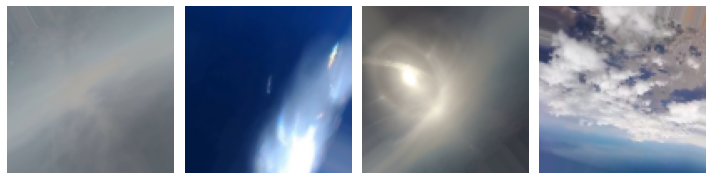

In [39]:
sample_training_images, labels= next(iter(train_ds))
print(labels[:4])
plotImages(sample_training_images[:4])

# Model definition

In [43]:
model_cnn = keras.models.Sequential()

model_cnn.add(keras.layers.Conv2D(32, (3,3), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((4,4)))

model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(512,  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Dropout(0.5))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.Dense(1, activation = "sigmoid"))

model_cnn.build((None, 100, 100, 3))
model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 batch_normalization_15 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 activation_36 (Activation)  (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 25, 25, 64)      

In [49]:
optimizer = optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

model_cnn.compile(loss='binary_crossentropy', optimizer =optimizer,
             metrics=['accuracy'])

# Model training

In [44]:
training_samples = train_ds.n
val_samples = val_ds.n

epochs = 30

history_cnn = model_cnn.fit(
    train_ds,
    steps_per_epoch=training_samples // batch_size,
    epochs = epochs,
    validation_data=val_ds,
    validation_steps=val_samples // batch_size,
)

Epoch 1/30
83/83 [==============================] - 50s 593ms/step - loss: 9.2351 - accuracy: 0.7509 - val_loss: 8.5317 - val_accuracy: 0.5219
Epoch 2/30
83/83 [==============================] - 47s 572ms/step - loss: 7.5467 - accuracy: 0.8365 - val_loss: 7.1647 - val_accuracy: 0.5375
Epoch 3/30
83/83 [==============================] - 46s 556ms/step - loss: 6.2892 - accuracy: 0.8857 - val_loss: 6.0952 - val_accuracy: 0.6531
Epoch 4/30
83/83 [==============================] - 46s 554ms/step - loss: 5.3450 - accuracy: 0.8978 - val_loss: 5.2057 - val_accuracy: 0.7937
Epoch 5/30
83/83 [==============================] - 47s 571ms/step - loss: 4.6318 - accuracy: 0.9182 - val_loss: 4.5536 - val_accuracy: 0.7625
Epoch 6/30
83/83 [==============================] - 48s 581ms/step - loss: 4.0670 - accuracy: 0.9069 - val_loss: 3.9661 - val_accuracy: 0.8406
Epoch 7/30
83/83 [==============================] - 47s 567ms/step - loss: 3.6078 - accuracy: 0.9228 - val_loss: 3.5658 - val_accuracy: 0.8500

In [45]:
def visualizacion_resultados(history):
  nepochs = [i for i in range(epochs)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(nepochs, train_acc, "-", label =" Training accuracy")
  ax[0].plot(nepochs, val_acc, "-", label= "Validation accuracy")
  ax[0].set_title("Training & validation accuracy")
  ax[0].legend()
  ax[0].set_xlabel("nEpochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(nepochs, train_loss, "go-", label =" Training Loss")
  ax[1].plot(nepochs, val_loss, "ro-", label= "Validation Loss")
  ax[1].set_title("Training & validation Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()


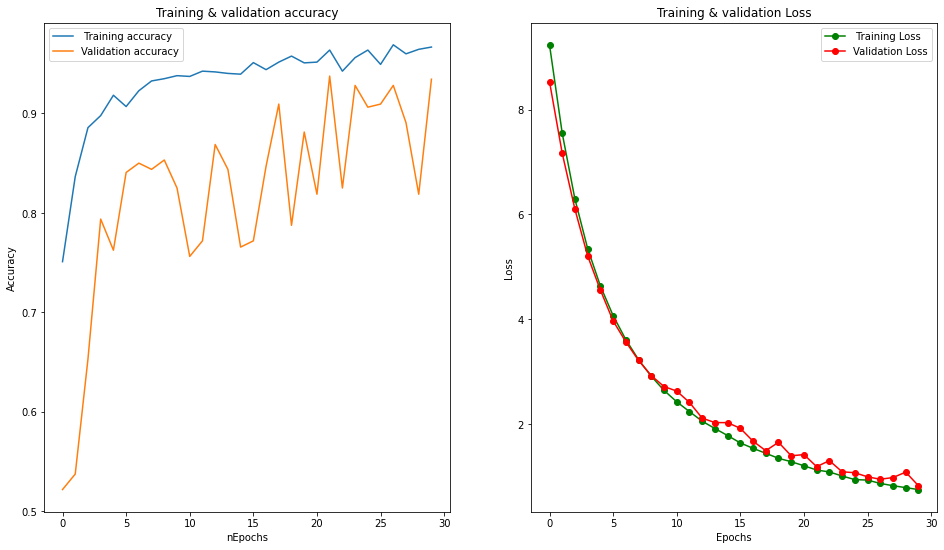

In [46]:
visualizacion_resultados(history_cnn)

# Tensorflow model evaluation

In [47]:
loss, accuracy = model_cnn.evaluate(val_ds)

21/21 [==============================] - 9s 410ms/step - loss: 0.8439 - accuracy: 0.9189


In [96]:
sample_training_images, true_label_id = next(iter(train_ds))

In [97]:
import time

start_time = time.time()
tf_model_predictions = model_cnn(sample_training_images)
end_time = time.time()

In [98]:
predicted_ids = []

for x in tf_model_predictions.numpy(): 
  if x > 0.5:
    predicted_ids.append(1)
  else: 
    predicted_ids.append(0)

print(predicted_ids)
print(true_label_id)

[1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
[1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


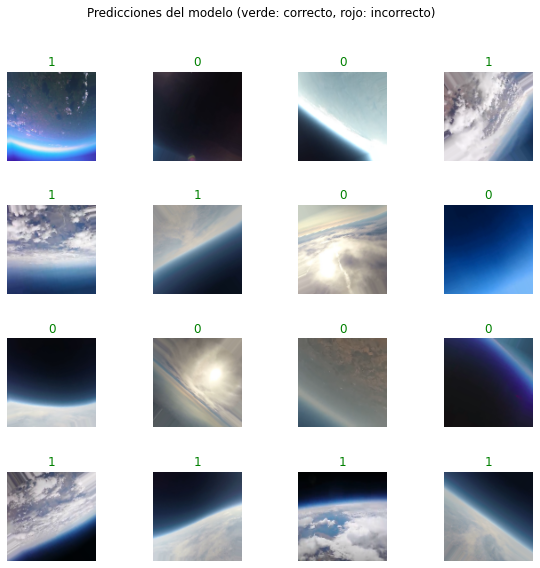

In [99]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(16):
  plt.subplot(4,4,n+1)
  plt.imshow(sample_training_images[n])
  color = "green" if predicted_ids[n] == true_label_id[n] else "red"
  plt.title(str(predicted_ids[n]).title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Predicciones del modelo (verde: correcto, rojo: incorrecto)")

# TFLite model quantization

In [100]:
TFLITE_MODEL_QUANTIZED = "cnn_quantized.tflite"

In [105]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int16]
tflite_model = converter.convert()

tflite_no_quant_file = "/content/model_cnn_quant.tflite"

with open(tflite_no_quant_file, "wb") as f:
  f.write(tflite_model)